In [1]:
#Python
#import module for predict
import os
import numpy as np
import configparser
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import recompose_img
from extract_patches import recompose_overlap_img
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from pre_processing import my_preprocessing

Using TensorFlow backend.
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bono/.pyenv/versions/3.5.5/envs/gpuTest/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

### init setting

In [2]:
#========= CONFIG FILE TO READ FROM =======
config = configparser.RawConfigParser()
config.read('configuration.txt')

#run the training on invariant or local
path_data = config.get('data paths', 'path_local')

In [3]:
print(path_data)

./hdf5_datasets_training_testing/


In [4]:
# original test images (for FOV selection)
# init setting (PATH, mode, parameter)
DRIVE_test_imgs_original = path_data + config.get('data paths', 'DRIVE_test_imgs_original')
test_imgs_orig = load_hdf5(DRIVE_test_imgs_original)
full_img_height = test_imgs_orig.shape[2]
full_img_width = test_imgs_orig.shape[3]
#the border masks provided by the DRIVE
DRIVE_test_border_masks = path_data + config.get('data paths', 'DRIVE_test_border_masks')
test_border_masks = load_hdf5(DRIVE_test_border_masks)

# gtruth
DRIVE_gtruth= path_data + config.get('data paths', 'DRIVE_test_groundTruth')

# dimension of the patches
patch_height = int(config.get('data attributes', 'patch_height'))
patch_width = int(config.get('data attributes', 'patch_width'))
#the stride in case output with average
stride_height = int(config.get('testing settings', 'stride_height'))
stride_width = int(config.get('testing settings', 'stride_width'))
assert (stride_height < patch_height and stride_width < patch_width)
#model name
name_experiment = config.get('experiment name', 'name')
target_train = config.get('experiment name', 'result_save_path')

path_experiment = './'+'result/'+target_train +'/'+ name_experiment
#N full images to be predicted
Imgs_to_test = int(config.get('testing settings', 'full_images_to_test'))
#Grouping of the predicted images
N_visual = int(config.get('testing settings', 'num_group_visual'))
#====== average mode ===========
average_mode = config.getboolean('testing settings', 'average_mode')



In [5]:
print(DRIVE_test_imgs_original)
print(path_experiment)

./hdf5_datasets_training_testing/DRIVE/DRIVE_dataset_imgs_test.hdf5
./result/Retina_Result/Dynamic_data_DRIVE


In [6]:
# visualizing
test_img_ori = load_hdf5(DRIVE_test_imgs_original)
test_img_border = load_hdf5(DRIVE_test_border_masks)
test_img_grd = load_hdf5(DRIVE_gtruth)

temp_tot_test1 = visualize(group_images(test_img_ori[0:20,:,:,:],5),path_experiment+'/imgs_test')
temp_tot_test2 = visualize(group_images(test_img_border[0:20,:,:,:],5),path_experiment+'/imgs_test_border')
temp_tot_test3 = visualize(group_images(test_img_grd[0:20,:,:,:],5), path_experiment+'/imgs_test_ground')

[group images func] prev data shape  : (20, 3, 584, 565)
[group images func] after data shape :  (20, 584, 565, 3)
[group images func] first total image :  (584, 2825, 3)
[group images func] final total image :  (2920, 2825, 3)
data shape :  (2920, 2825, 3)
<PIL.Image.Image image mode=RGB size=2825x2920 at 0x7F3283D1AC88>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/imgs_test
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 2825, 1)
[group images func] final total image :  (2920, 2825, 1)
data shape :  (2920, 2825, 1)
<PIL.Image.Image image mode=L size=2825x2920 at 0x7F326777F358>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/imgs_test_border
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 2825, 1)
[group images func] final total image :  (2920

In [7]:
#============ Load the data and divide in patches
patches_imgs_test = None
new_height = None
new_width = None
masks_test  = None
patches_masks_test = None
if average_mode == True:
    patches_imgs_test, new_height, new_width, masks_test = get_data_testing_overlap(
        DRIVE_test_img_ori_path = DRIVE_test_imgs_original,  #original
        DRIVE_test_img_grd_path = path_data + config.get('data paths', 'DRIVE_test_groundTruth'),  #masks
        num_test_img = int(config.get('testing settings', 'full_images_to_test')),
        patch_h = patch_height,
        patch_w = patch_width,
        stride_h = stride_height,
        stride_w = stride_width
    )
else:
    patches_imgs_test, patches_masks_test = get_data_testing(
        DRIVE_test_img_ori_path = DRIVE_test_imgs_original,  #original
        DRIVE_test_img_grd_path = path_data + config.get('data paths', 'DRIVE_test_groundTruth'),  #masks
        num_test_img = int(config.get('testing settings', 'full_images_to_test')),
        patch_h = patch_height,
        patch_w = patch_width
    )

[DEBUG] normalize shape :  (20, 1, 584, 565)
[DEBUG] i normalize shape :  (1, 584, 565)
type :  <class 'numpy.ndarray'>
[get data testing func] prev test img shape : (20, 1, 584, 565) ground truth shape : (20, 1, 584, 565) 
this ? :  data shape :  20 1 624 576
this ? :  data shape :  20 1 624 576
[get data testing func] after test img shape : (20, 1, 624, 576) ground truth shape : (20, 1, 624, 576) 
[get_data_testing_func] test images range (min-max): 0.0 - 1.0
[get_data_testing_fucn] test masks are within 0-1

[extract order func] patches h : 13 patches w : 12
[extract order func] number of patches : 3120
[extract order func] patches h : 13 patches w : 12
[extract order func] number of patches : 3120

[get_data_testing_fucn] test PATCHES images/grds shape:
(3120, 1, 48, 48)
[get_data_testing_fucn] test PATCHES images range (min-max): 0.0 - 1.0


In [8]:
print(path_experiment+'/'+ name_experiment +'_architecture.json')
print(path_experiment)

./result/Retina_Result/Dynamic_data_DRIVE/Dynamic_data_DRIVE_architecture.json
./result/Retina_Result/Dynamic_data_DRIVE


In [9]:
print(np.shape(patches_imgs_test))

(3120, 1, 48, 48)


In [10]:
#================ Run the prediction of the patches ==================================
best_last = config.get('testing settings', 'best_last')
#Load the saved model
model = model_from_json(open(path_experiment+'/'+ name_experiment +'_architecture.json').read())
model.load_weights(path_experiment+'/'+best_last+'_weights.h5')
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=64, verbose=2)
print ("predicted images size :",predictions.shape)


predicted images size : (3120, 2304, 2)


In [11]:
#===== Convert the prediction arrays in corresponding images
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")
pred_patches_thr = pred_to_imgs(predictions, patch_height, patch_width, "threshold")

In [12]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = None
orig_imgs = None
gtruth_masks = None

if average_mode == True:
    pred_imgs = recompose_overlap_img(pred_patches, new_height, new_width, stride_height, stride_width)# predictions
    pred_imgs_thr = recompose_overlap_img(pred_patches_thr, new_height, new_width, stride_height, stride_width)# predictions

    orig_imgs = my_preprocessing(test_imgs_orig[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = masks_test  #ground truth masks
    

else:
    pred_imgs = recompose_img(pred_patches,13,12)       # predictions
    pred_imgs_thr = recompose_img(pred_patches_thr,13,12)       # predictions
    orig_imgs = recompose_img(patches_imgs_test,13,12)  # originals
    gtruth_masks = recompose_img(patches_masks_test,13,12)  #masks



[DEBUG] data shape :  (3120, 1, 48, 48)
[DEBUG] full recomp shape :  (20, 1, 624, 576)
[DEBUG] full result shape :  (20, 1, 624, 576)
[DEBUG] data shape :  (3120, 1, 48, 48)
[DEBUG] full recomp shape :  (20, 1, 624, 576)
[DEBUG] full result shape :  (20, 1, 624, 576)
[DEBUG] data shape :  (3120, 1, 48, 48)
[DEBUG] full recomp shape :  (20, 1, 624, 576)
[DEBUG] full result shape :  (20, 1, 624, 576)
[DEBUG] data shape :  (3120, 1, 48, 48)
[DEBUG] full recomp shape :  (20, 1, 624, 576)
[DEBUG] full result shape :  (20, 1, 624, 576)


In [13]:
print(np.shape(pred_imgs))
print(path_experiment)

(20, 1, 624, 576)
./result/Retina_Result/Dynamic_data_DRIVE


### Original mode

In [14]:
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!

print(np.shape(pred_imgs))
kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
print(np.shape(pred_imgs))
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print ("Orig imgs shape: " +str(orig_imgs.shape))
print ("pred imgs shape: " +str(pred_imgs.shape))
print ("Gtruth imgs shape: " +str(gtruth_masks.shape))


visualize(group_images(orig_imgs,N_visual),path_experiment+'/'+"all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),path_experiment+'/'+"all_predictions")#.show()
visualize(group_images(gtruth_masks,N_visual),path_experiment+'/'+"all_groundTruths")#.show()
#visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
print('N_visual : ', group)


(20, 1, 624, 576)
(20, 1, 624, 576)
Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (12264, 565, 1)
data shape :  (12264, 565, 1)
<PIL.Image.Image image mode=L size=565x12264 at 0x7F324C527320>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/all_originals
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (12264, 565, 1)
data shape :  (12264, 565, 1)
<PIL.Image.Image image mode=L size=565x12264 at 0x7F324C527438>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/all_predictions
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func

In [15]:
result_path = 'each_results'
if os.path.isdir(path_experiment+'/'+result_path) == False:
    os.mkdir(path_experiment+'/' +result_path)
else:
    print('already exist the folder in this path : {}'.format(path_experiment +result_path))

for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    
    visualize(pred_stripe,path_experiment+'/'+ result_path +'/'+"_Prediction"+str(i))#.show()
    visualize(total_img,path_experiment+'/'+ result_path +'/'+"_Original_GroundTruth_Prediction"+str(i))#.show()

[group images func] prev data shape  : (1, 1, 584, 565)
[group images func] after data shape :  (1, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (1168, 565, 1)
[group images func] prev data shape  : (1, 1, 584, 565)
[group images func] after data shape :  (1, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (1168, 565, 1)
[group images func] prev data shape  : (1, 1, 584, 565)
[group images func] after data shape :  (1, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (1168, 565, 1)
data shape :  (1168, 565, 1)
<PIL.Image.Image image mode=L size=565x1168 at 0x7F324C50FFD0>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/each_results/_Prediction0
data shape :  (3504, 565, 1)
<PIL.Image.Image image mode=L size=565x3504 at 0x7F324C50FFD0>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/each_res

In [16]:
print(np.shape(pred_imgs))

y_scores, y_true = pred_only_FOV(pred_imgs, gtruth_masks, test_border_masks)
print ("Calculating results only inside the FOV:")
print ("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print ("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")


(20, 1, 584, 565)
Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)



Area under the ROC curve: 0.9340129379544925


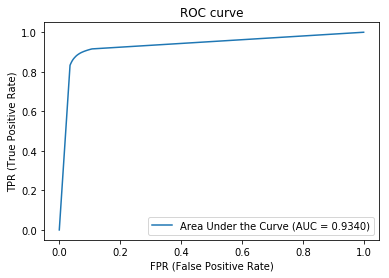

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score


#roc curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print ("\nArea under the ROC curve: " +str(auc_roc))
roc_curve = plt.figure()

plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % auc_roc)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+'/'+"ROC.png")




Area under Precision-Recall curve: 0.8260890631431668


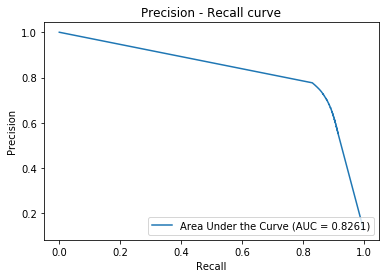

In [18]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()

plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+'/'+"Precision_recall.png")

In [19]:
# confusion matrix

threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
        
confusion = confusion_matrix(y_true, y_pred)
print (confusion)


Confusion matrix:  Custom threshold (for positive) of 0.5
[[3811701  148793]
 [  91926  485723]]


In [20]:
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))

specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

Global Accuracy: 0.9469564974043347
Specificity: 0.9624306967767152
Sensitivity: 0.8408618382443318
Precision: 0.7655015791563964


In [21]:

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(path_experiment+'/performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(auc_roc)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()


Jaccard similarity score: 0.9469564974043347

F1 score (F-measure): 0.801413998919289


### Threshold mode

In [22]:
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
kill_border(pred_imgs_thr, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs_thr = pred_imgs_thr[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print ("Orig imgs shape: " +str(orig_imgs.shape))
print ("pred imgs shape: " +str(pred_imgs.shape))
print ("Gtruth imgs shape: " +str(gtruth_masks.shape))

def save_all_predict_img_for_evalutation(img, target_path):
    from PIL import Image
    if os.path.isdir(target_path) == False:
        os.mkdir(target_path)
    else:
        print('already exist the folder in this path : {}'.format(target_path))
    
    # img shape = [num, ch, h, w]
    # dtype = binary img
    
    num_img = len(img)
    save_result_path = target_path
    print('path information : ', save_result_path)
    temp_save_img = None
    for i in range(num_img):
        if np.max(img[i,0]) > 1:
            temp_save_img = Image.fromarray(img[i,0].astype(np.uint8))
        else:
            temp_save_img = Image.fromarray((img[i,0]*255).astype(np.uint8))
            
        temp_save_img.save(save_result_path+ str(i+1)+'.png')
    
    print('[Done]')


save_all_predict_img_for_evalutation(pred_imgs_thr,path_experiment+'/'+'submission_result_thr/')
    
    



Orig imgs shape: (20, 1, 584, 565)
pred imgs shape: (20, 1, 584, 565)
Gtruth imgs shape: (20, 1, 584, 565)
path information :  ./result/Retina_Result/Dynamic_data_DRIVE/submission_result_thr/
[Done]


In [23]:

visualize(group_images(orig_imgs,N_visual),path_experiment+'/'+"all_originals_thr")#.show()
visualize(group_images(pred_imgs_thr,N_visual),path_experiment+'/'+"all_predictions_thr")#.show()
visualize(group_images(gtruth_masks,N_visual),path_experiment+'/'+"all_groundTruths_thr")#.show()
#visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs_thr.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)

result_path = 'each_results_thr'
if os.path.isdir(path_experiment+'/'+result_path) == False:
    os.mkdir(path_experiment+'/' +result_path)
else:
    print('already exist the folder in this path : {}'.format(path_experiment +result_path))

for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs_thr[i*group:(i*group)+group,:,:,:],group)
    total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    
    visualize(pred_stripe,path_experiment+'/'+ result_path +'/'+"_Prediction"+str(i))#.show()
    visualize(total_img,path_experiment+'/'+ result_path +'/'+"_Original_GroundTruth_Prediction"+str(i))#.show()

[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (12264, 565, 1)
data shape :  (12264, 565, 1)
<PIL.Image.Image image mode=L size=565x12264 at 0x7F324C53D208>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/all_originals_thr
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image :  (12264, 565, 1)
data shape :  (12264, 565, 1)
<PIL.Image.Image image mode=L size=565x12264 at 0x7F324C53D320>
file name :  ./result/Retina_Result/Dynamic_data_DRIVE/all_predictions_thr
[group images func] prev data shape  : (20, 1, 584, 565)
[group images func] after data shape :  (20, 584, 565, 1)
[group images func] first total image :  (584, 565, 1)
[group images func] final total image : 

In [24]:
y_scores, y_true = pred_only_FOV(pred_imgs_thr, gtruth_masks, test_border_masks)
print ("Calculating results only inside the FOV:")
print ("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print ("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")


Calculating results only inside the FOV:
y scores pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)
y true pixels: 4538143 (radius 270: 270*270*3.14==228906), including background around retina: 6599200 (584*565==329960)



Area under the ROC curve: 0.9016462675105235


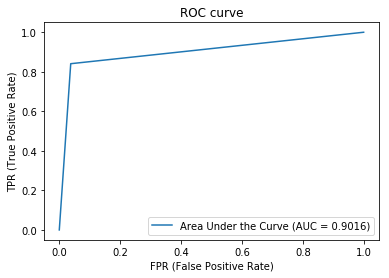

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score


#roc curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print ("\nArea under the ROC curve: " +str(auc_roc))
roc_curve = plt.figure()

plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % auc_roc)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(path_experiment+'/'+"ROC_thr.png")




Area under Precision-Recall curve: 0.8133098602372373


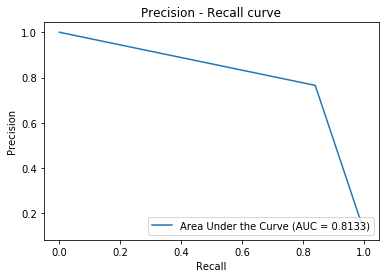

In [26]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0]  #so the array is increasing (you won't get negative AUC)
recall = np.fliplr([recall])[0]  #so the array is increasing (you won't get negative AUC)
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()

plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(path_experiment+'/'+"Precision_recall_thr.png")

In [27]:
# confusion matrix

threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
        
confusion = confusion_matrix(y_true, y_pred)
print (confusion)


Confusion matrix:  Custom threshold (for positive) of 0.5
[[3811701  148793]
 [  91926  485723]]


In [28]:
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))

specificity = 0
#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#Save the results
file_perf = open(path_experiment+'/performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(auc_roc)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()


Global Accuracy: 0.9469564974043347

Jaccard similarity score: 0.9469564974043347

F1 score (F-measure): 0.801413998919289
Specificity: 0.9624306967767152
Sensitivity: 0.8408618382443318
Precision: 0.7655015791563964


In [29]:

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(path_experiment+'/performances_thr.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(auc_roc)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()


Jaccard similarity score: 0.9469564974043347

F1 score (F-measure): 0.801413998919289
